# NASA Exoplanet Data Cleaning & Wrangling

**Project:** K-Means Clustering Analysis of NASA Exoplanets 
---

## Objectives

This notebook demonstrates professional data wrangling practices:
   
1. **Identify and analyze missing values** in raw data
2. **Filter to complete cases** for clustering analysis
3. **Create derived variables** (density calculation)
4. **Standardize text fields** for consistency
5. **Detect and remove outliers** using statistical methods
6. **Export clean dataset** for downstream analysis

---

## Learning Outcomes Demonstrated

- ✅ Pandas data manipulation
- ✅ Missing value analysis and handling
- ✅ Data quality assessment
- ✅ Outlier detection methods
- ✅ Feature engineering
- ✅ Documentation and reproducibility

## 1. Setup and Data Loading

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"Notebook execution started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Notebook execution started: 2025-12-06 11:25:15


In [22]:
# Load raw data
INPUT_FILE = 'raw_exoplanets.csv'
OUTPUT_FILE = 'cleaned_exoplanets.csv'

print(f"Loading data from: {INPUT_FILE}")
df_raw = pd.read_csv(INPUT_FILE)

print(f"\n✓ Data loaded successfully!")
print(f"  Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"\nColumn names:\n{df_raw.columns.tolist()}")

Loading data from: raw_exoplanets.csv

✓ Data loaded successfully!
  Shape: 39,158 rows × 9 columns

Column names:
['pl_name', 'pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'sy_dist', 'discoverymethod', 'disc_year', 'hostname']


In [23]:
# Display first few rows
print("First 5 rows of raw data:")
df_raw.head()

First 5 rows of raw data:


,pl_name,pl_masse,pl_rade,pl_orbper,pl_eqt,sy_dist,discoverymethod,disc_year,hostname
0,WASP-39 b,88.9890,14.2350,4.0553,NaN,213.9820,Transit,2011,WASP-39
1,HAT-P-1 b,169.0856,13.9216,4.4654,1306.0000,158.9790,Transit,2006,HAT-P-1
2,HR 8799 d,3000.0000,13.0000,37000.0000,NaN,41.2441,Imaging,2008,HR 8799
3,HD 156279 b,NaN,NaN,131.0500,NaN,36.1945,Radial Velocity,2011,HD 156279
4,GJ 832 b,NaN,NaN,3507.0000,NaN,4.9643,Radial Velocity,2008,GJ 832


In [24]:
# Basic info about the dataset
print("Dataset Information:")
df_raw.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39158 entries, 0 to 39157
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pl_name          39158 non-null  object 
 1   pl_masse         4740 non-null   float64
 2   pl_rade          26999 non-null  float64
 3   pl_orbper        35879 non-null  float64
 4   pl_eqt           17159 non-null  float64
 5   sy_dist          38314 non-null  float64
 6   discoverymethod  39158 non-null  object 
 7   disc_year        39158 non-null  int64  
 8   hostname         39158 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 2.7+ MB


## 2. Missing Value Analysis

Before cleaning, we need to understand the extent and pattern of missing data.

In [25]:
# Create comprehensive missing value report
def analyze_missing_values(df):
    """
    Generate detailed missing value analysis.
    
    Parameters:
    ----------
    df : pd.DataFrame
        Input dataframe to analyze
    
    Returns:
    -------
    pd.DataFrame : Missing value statistics
    """
    missing_stats = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum().values,
        'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2),
        'Data_Type': df.dtypes.values,
        'Non_Null_Count': df.notnull().sum().values
    })
    
    # Sort by missing percentage
    missing_stats = missing_stats.sort_values('Missing_Percentage', ascending=False)
    missing_stats = missing_stats.reset_index(drop=True)
    
    return missing_stats

missing_report = analyze_missing_values(df_raw)
print("\n" + "="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)
print(missing_report)
print("="*80)


MISSING VALUE ANALYSIS
            Column  Missing_Count  Missing_Percentage Data_Type  \
0         pl_masse          34418             87.9000   float64   
1           pl_eqt          21999             56.1800   float64   
2          pl_rade          12159             31.0500   float64   
3        pl_orbper           3279              8.3700   float64   
4          sy_dist            844              2.1600   float64   
5          pl_name              0              0.0000    object   
6  discoverymethod              0              0.0000    object   
7        disc_year              0              0.0000     int64   
8         hostname              0              0.0000    object   

   Non_Null_Count  
0            4740  
1           17159  
2           26999  
3           35879  
4           38314  
5           39158  
6           39158  
7           39158  
8           39158  


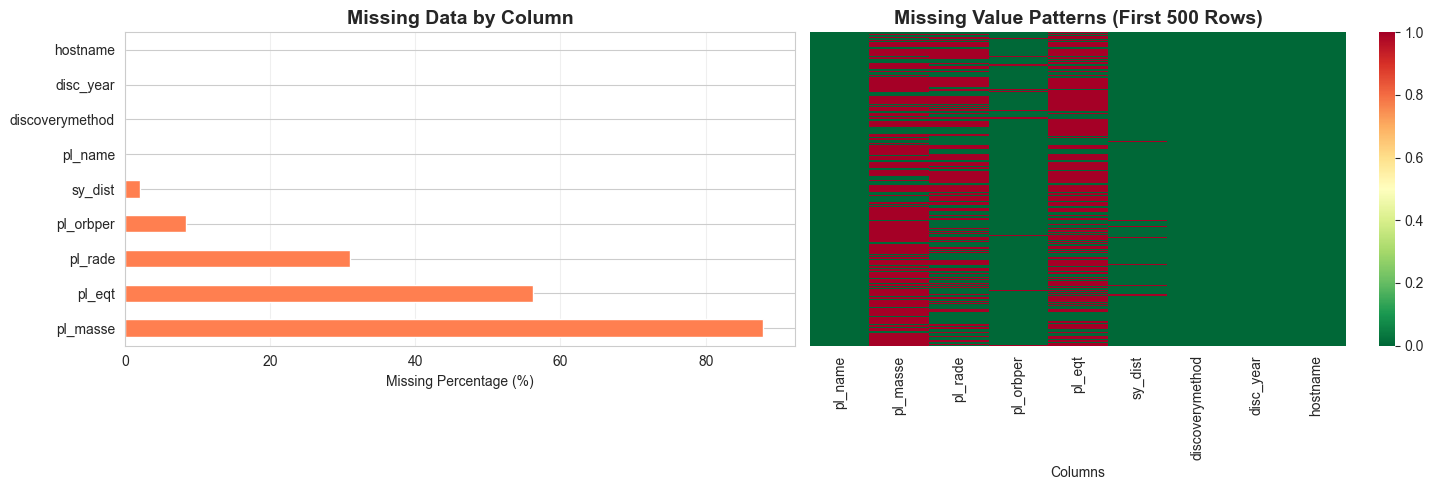


✓ Visualization saved as 'missing_values_analysis.png'


In [26]:
# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of missing percentages
missing_pct = (df_raw.isnull().sum() / len(df_raw) * 100).sort_values(ascending=False)
ax1 = axes[0]
missing_pct.plot(kind='barh', ax=ax1, color='coral')
ax1.set_xlabel('Missing Percentage (%)')
ax1.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Heatmap of missing values (sample of data)
ax2 = axes[1]
sample_size = min(500, len(df_raw))
sns.heatmap(df_raw.head(sample_size).isnull(), 
            cbar=True, 
            yticklabels=False,
            cmap='RdYlGn_r',
            ax=ax2)
ax2.set_title(f'Missing Value Patterns (First {sample_size} Rows)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Columns')

plt.tight_layout()
plt.savefig('missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved as 'missing_values_analysis.png'")

## 3. Filter to Complete Cases

For clustering analysis, we need complete data for our key numerical features:
- `pl_masse` (mass)
- `pl_rade` (radius)
- `pl_orbper` (orbital period)
- `pl_eqt` (equilibrium temperature)

In [27]:
# Define critical features for clustering
CRITICAL_FEATURES = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt']

print("Critical features for clustering analysis:")
for i, feat in enumerate(CRITICAL_FEATURES, 1):
    print(f"  {i}. {feat}")

# Check completeness before filtering
print(f"\nBefore filtering:")
print(f"  Total planets: {len(df_raw):,}")
for feat in CRITICAL_FEATURES:
    missing = df_raw[feat].isnull().sum()
    pct = (missing / len(df_raw) * 100)
    print(f"  {feat}: {missing:,} missing ({pct:.2f}%)")

Critical features for clustering analysis:
  1. pl_masse
  2. pl_rade
  3. pl_orbper
  4. pl_eqt

Before filtering:
  Total planets: 39,158
  pl_masse: 34,418 missing (87.90%)
  pl_rade: 12,159 missing (31.05%)
  pl_orbper: 3,279 missing (8.37%)
  pl_eqt: 21,999 missing (56.18%)


In [28]:
# Create working copy and filter to complete cases
df_clean = df_raw.copy()

# Filter to rows with all critical features present
mask_complete = df_clean[CRITICAL_FEATURES].notnull().all(axis=1)
df_clean = df_clean[mask_complete].copy()

print(f"\nAfter filtering to complete cases:")
print(f"  Total planets: {len(df_clean):,}")
print(f"  Rows removed: {len(df_raw) - len(df_clean):,}")
print(f"  Retention rate: {(len(df_clean) / len(df_raw) * 100):.2f}%")

# Verify no missing values in critical features
print(f"\nVerification - Missing values in critical features:")
print(df_clean[CRITICAL_FEATURES].isnull().sum())


After filtering to complete cases:
  Total planets: 1,776
  Rows removed: 37,382
  Retention rate: 4.54%

Verification - Missing values in critical features:
pl_masse     0
pl_rade      0
pl_orbper    0
pl_eqt       0
dtype: int64


## 4. Create Derived Variables

### Calculate Density

Density is a crucial physical property for planet classification:

$$\\text{Density} = \\frac{\\text{Mass}}{\\text{Volume}} = \\frac{\\text{Mass}}{\\frac{4}{3}\\pi r^3}$$

For relative density (compared to Earth):
$$\\text{Relative Density} = \\frac{\\text{Mass (Earth masses)}}{\\text{Radius}^3 \\text{ (Earth radii)}^3}$$

In [29]:
# Calculate density (mass/radius^3)
# This gives us relative density compared to Earth
df_clean['density'] = df_clean['pl_masse'] / (df_clean['pl_rade'] ** 3)

print("Density calculation complete!\n")
print("Density statistics (relative to Earth):")
print(df_clean['density'].describe())

# Reference values for context
print("\n📊 Reference densities (relative to Earth = 1.0):")
print("  • Gas giants (Jupiter): ~0.24")
print("  • Ice giants (Neptune): ~0.30")
print("  • Rocky planets (Earth): ~1.00")
print("  • Super-Earths: ~0.8-1.2")

Density calculation complete!

Density statistics (relative to Earth):
count   1776.0000
mean       1.7971
std       26.5537
min        0.0055
25%        0.1064
50%        0.2637
75%        0.7189
max      791.3313
Name: density, dtype: float64

📊 Reference densities (relative to Earth = 1.0):
  • Gas giants (Jupiter): ~0.24
  • Ice giants (Neptune): ~0.30
  • Rocky planets (Earth): ~1.00
  • Super-Earths: ~0.8-1.2


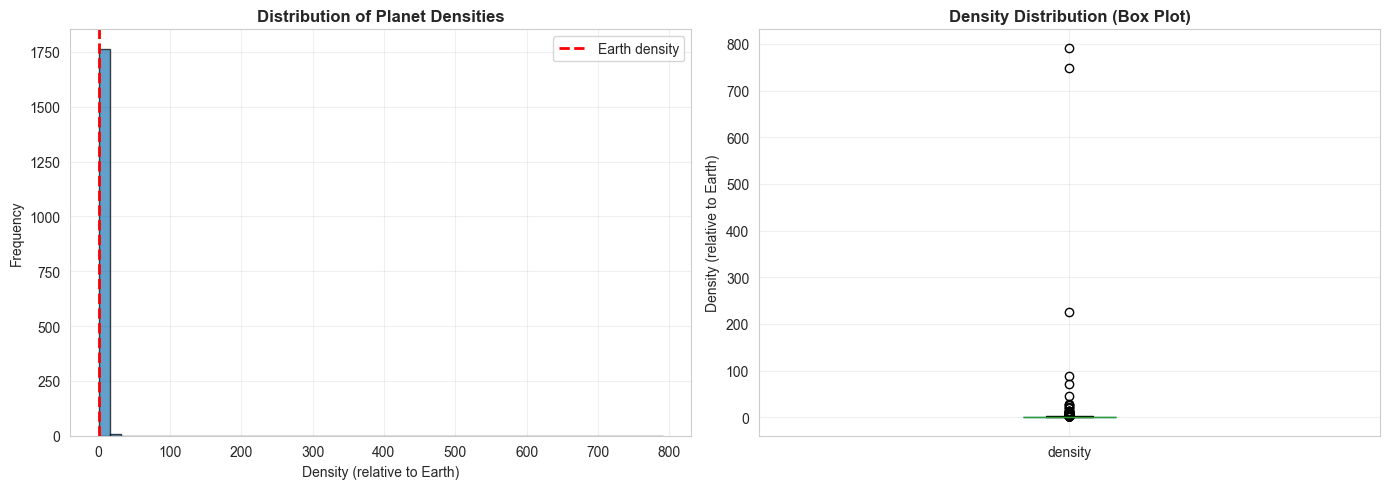


✓ Visualization saved as 'density_distribution.png'


In [30]:
# Visualize density distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
df_clean['density'].hist(bins=50, edgecolor='black', alpha=0.7, ax=ax1)
ax1.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Earth density')
ax1.set_xlabel('Density (relative to Earth)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Planet Densities', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2 = axes[1]
df_clean.boxplot(column='density', ax=ax2, patch_artist=True)
ax2.set_ylabel('Density (relative to Earth)')
ax2.set_title('Density Distribution (Box Plot)', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('density_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'density_distribution.png'")

## 5. Standardize Text Fields

Text standardization ensures consistency in categorical variables.

In [31]:
# Examine text fields before standardization
print("Text fields before standardization:\n")

print("1. Planet Names (pl_name) - Sample:")
print(df_clean['pl_name'].head(10).tolist())

print("\n2. Discovery Methods (discoverymethod) - Unique values:")
print(df_clean['discoverymethod'].value_counts())

print("\n3. Host Star Names (hostname) - Sample:")
print(df_clean['hostname'].head(10).tolist())

Text fields before standardization:

1. Planet Names (pl_name) - Sample:
['HAT-P-1 b', 'GJ 3470 b', 'WASP-96 b', 'GJ 3470 b', 'HAT-P-11 b', 'GJ 1214 b', 'HAT-P-1 b', 'WASP-19 b', 'WASP-19 b', 'HAT-P-1 b']

2. Discovery Methods (discoverymethod) - Unique values:
discoverymethod
Transit                          1715
Radial Velocity                    53
Imaging                             7
Orbital Brightness Modulation       1
Name: count, dtype: int64

3. Host Star Names (hostname) - Sample:
['HAT-P-1', 'GJ 3470', 'WASP-96', 'GJ 3470', 'HAT-P-11', 'GJ 1214', 'HAT-P-1', 'WASP-19', 'WASP-19', 'HAT-P-1']


In [32]:
def standardize_text_fields(df):
    """
    Standardize text fields for consistency.
    
    Operations:
    - Strip whitespace
    - Standardize discovery method names
    - Ensure consistent capitalization for names
    
    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame to standardize
    
    Returns:
    -------
    pd.DataFrame : Standardized DataFrame
    """
    df = df.copy()
    
    # Strip whitespace from all string columns
    string_columns = df.select_dtypes(include=['object']).columns
    for col in string_columns:
        df[col] = df[col].str.strip()
    
    # Standardize discovery methods (capitalize consistently)
    if 'discoverymethod' in df.columns:
        df['discoverymethod'] = df['discoverymethod'].str.title()
    
    # Planet names: ensure no leading/trailing spaces
    if 'pl_name' in df.columns:
        df['pl_name'] = df['pl_name'].str.strip()
    
    # Host star names: ensure no leading/trailing spaces  
    if 'hostname' in df.columns:
        df['hostname'] = df['hostname'].str.strip()
    
    return df

# Apply standardization
df_clean = standardize_text_fields(df_clean)

print("✓ Text fields standardized successfully!\n")
print("Discovery Methods after standardization:")
print(df_clean['discoverymethod'].value_counts())

✓ Text fields standardized successfully!

Discovery Methods after standardization:
discoverymethod
Transit                          1715
Radial Velocity                    53
Imaging                             7
Orbital Brightness Modulation       1
Name: count, dtype: int64


We'll use multiple methods to detect outliers:
1. **IQR Method** (Interquartile Range)
2. **Z-Score Method** (Statistical)
3. **Domain Knowledge** (Physical constraints)

In [33]:
def detect_outliers_iqr(df, column, multiplier=3.0):
    """
    Detect outliers using the IQR method.
    
    Parameters:
    ----------
    df : pd.DataFrame
        Input dataframe
    column : str
        Column name to check for outliers
    multiplier : float
        IQR multiplier (default 3.0 for extreme outliers)
    
    Returns:
    -------
    pd.Series : Boolean mask (True = outlier)
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    print(f"\n{column}:")
    print(f"  Q1: {Q1:.4f}, Q3: {Q3:.4f}, IQR: {IQR:.4f}")
    print(f"  Bounds: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"  Outliers detected: {outliers.sum():,} ({outliers.sum()/len(df)*100:.2f}%)")
    
    return outliers

# Detect outliers in numerical features
print("="*80)
print("OUTLIER DETECTION (IQR Method, multiplier=3.0)")
print("="*80)

numerical_features = ['pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'density']
outlier_masks = {}

for feature in numerical_features:
    outlier_masks[feature] = detect_outliers_iqr(df_clean, feature, multiplier=3.0)

# Combined outlier mask (any feature is an outlier)
combined_outliers = pd.Series(False, index=df_clean.index)
for mask in outlier_masks.values():
    combined_outliers = combined_outliers | mask

print(f"\n{'='*80}")
print(f"Total rows with ANY outlier: {combined_outliers.sum():,} ({combined_outliers.sum()/len(df_clean)*100:.2f}%)")
print(f"{'='*80}")

OUTLIER DETECTION (IQR Method, multiplier=3.0)

pl_masse:
  Q1: 9.6600, Q3: 340.3855, IQR: 330.7255
  Bounds: [-982.5164, 1332.5619]
  Outliers detected: 89 (5.01%)

pl_rade:
  Q1: 2.5315, Q3: 13.6750, IQR: 11.1434
  Bounds: [-30.8988, 47.1053]
  Outliers detected: 0 (0.00%)

pl_orbper:
  Q1: 2.7760, Q3: 9.9658, IQR: 7.1898
  Bounds: [-18.7935, 31.5352]
  Outliers detected: 135 (7.60%)

pl_eqt:
  Q1: 714.6450, Q3: 1561.2500, IQR: 846.6050
  Bounds: [-1825.1700, 4101.0650]
  Outliers detected: 0 (0.00%)

density:
  Q1: 0.1064, Q3: 0.7189, IQR: 0.6125
  Bounds: [-1.7310, 2.5562]
  Outliers detected: 70 (3.94%)

Total rows with ANY outlier: 258 (14.53%)


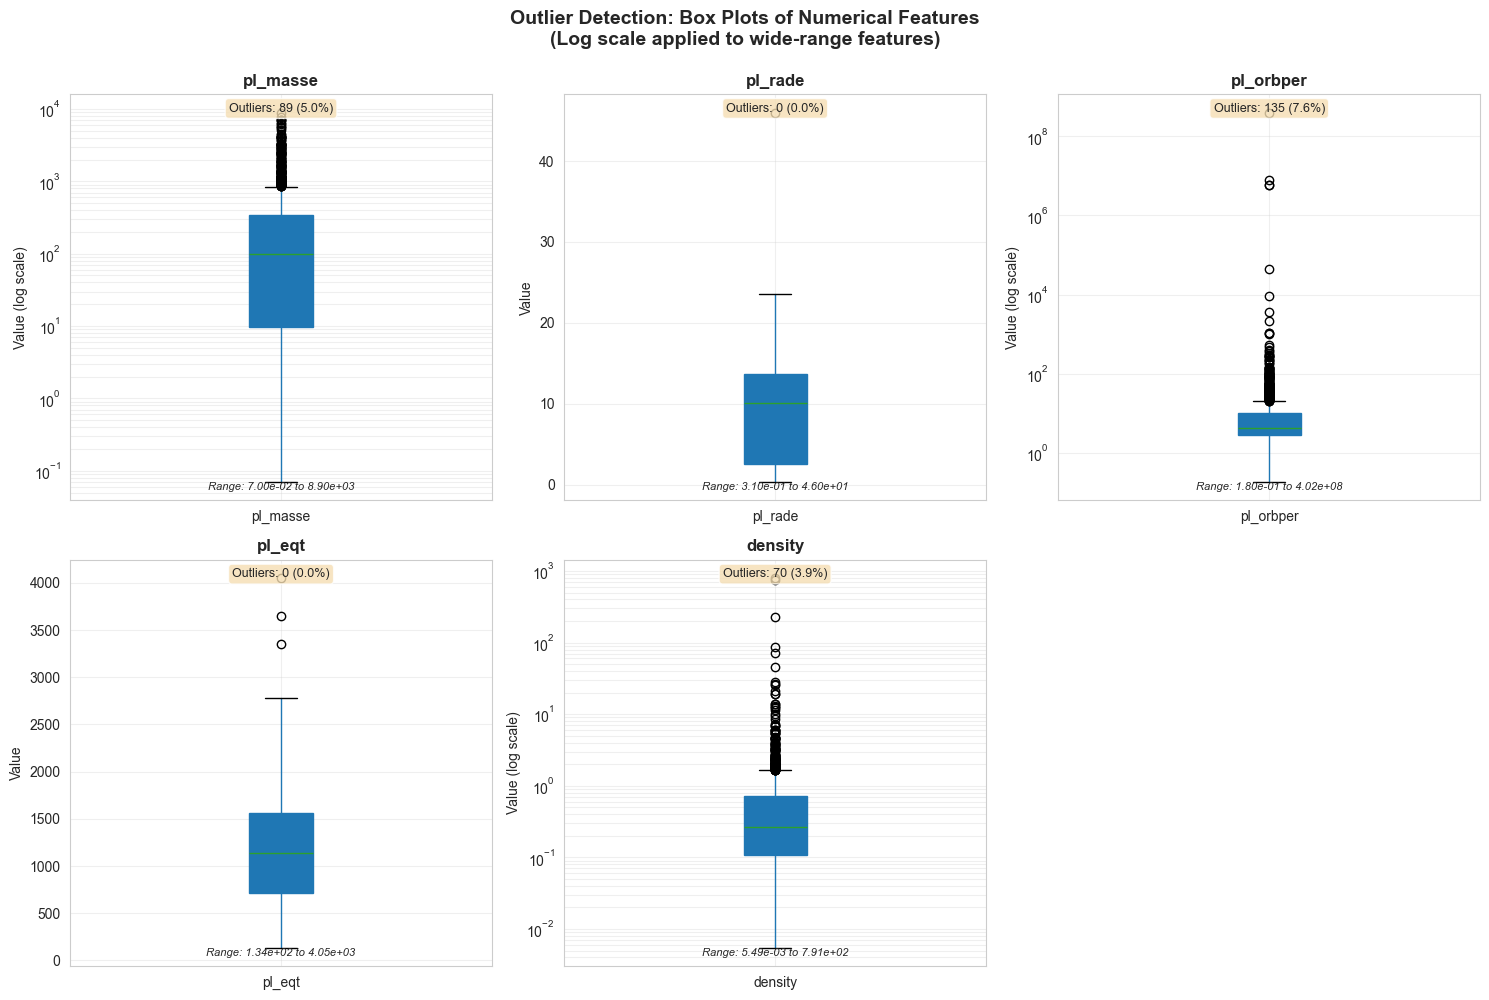


✓ Visualization saved as 'outliers_detection.png'


In [34]:
# Visualize outliers with log scale for better visibility
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    
    # Create box plot with log scale for features with wide ranges
    df_clean.boxplot(column=feature, ax=ax, patch_artist=True)
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Value')
    
    # Apply log scale to features with extreme ranges
    if feature in ['pl_masse', 'pl_orbper', 'density']:
        ax.set_yscale('log')
        ax.set_ylabel('Value (log scale)')
    
    ax.grid(alpha=0.3, which='both')
    
    # Add count of outliers
    n_outliers = outlier_masks[feature].sum()
    pct_outliers = (n_outliers / len(df_clean) * 100)
    ax.text(0.5, 0.98, f'Outliers: {n_outliers} ({pct_outliers:.1f}%)', 
            transform=ax.transAxes, 
            ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)
    
    # Add range info
    feature_min = df_clean[feature].min()
    feature_max = df_clean[feature].max()
    ax.text(0.5, 0.02, f'Range: {feature_min:.2e} to {feature_max:.2e}', 
            transform=ax.transAxes, 
            ha='center', va='bottom',
            fontsize=8, style='italic')

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Outlier Detection: Box Plots of Numerical Features\n(Log scale applied to wide-range features)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('outliers_detection.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'outliers_detection.png'")

In [35]:
# Apply domain knowledge filters
print("\nApplying domain knowledge filters:\n")

# Physical constraints
# 1. Density must be positive and reasonable (0.01 to 100 relative to Earth)
valid_density = (df_clean['density'] > 0.01) & (df_clean['density'] < 100)
print(f"1. Valid density range (0.01 to 100): Removed {(~valid_density).sum():,} planets")

# 2. Mass and radius must be positive
valid_mass_radius = (df_clean['pl_masse'] > 0) & (df_clean['pl_rade'] > 0)
print(f"2. Positive mass and radius: Removed {(~valid_mass_radius).sum():,} planets")

# 3. Orbital period must be positive
valid_period = df_clean['pl_orbper'] > 0
print(f"3. Positive orbital period: Removed {(~valid_period).sum():,} planets")

# 4. Temperature must be positive and below stellar surface temp (~50,000 K max)
valid_temp = (df_clean['pl_eqt'] > 0) & (df_clean['pl_eqt'] < 5000)
print(f"4. Reasonable temperature (0-5000 K): Removed {(~valid_temp).sum():,} planets")

# Combine all validity checks
valid_data = valid_density & valid_mass_radius & valid_period & valid_temp
print(f"\nTotal planets failing domain checks: {(~valid_data).sum():,}")


Applying domain knowledge filters:

1. Valid density range (0.01 to 100): Removed 9 planets
2. Positive mass and radius: Removed 0 planets
3. Positive orbital period: Removed 0 planets
4. Reasonable temperature (0-5000 K): Removed 0 planets

Total planets failing domain checks: 9


In [36]:
print("\nRemoving outliers and invalid data...\n")
print(f"Before outlier removal: {len(df_clean):,} planets")

# Keep only valid data (non-outliers based on domain knowledge)
df_clean = df_clean[valid_data].copy()

# Additionally remove extreme statistical outliers (using IQR method)
# We'll be more conservative and only remove the most extreme outliers
df_clean = df_clean[~combined_outliers].copy()

print(f"After outlier removal: {len(df_clean):,} planets")
print(f"Planets removed: {len(df_raw) - len(df_clean):,}")
print(f"Retention rate: {(len(df_clean) / len(df_raw) * 100):.2f}%")


Removing outliers and invalid data...

Before outlier removal: 1,776 planets
After outlier removal: 1,515 planets
Planets removed: 37,643
Retention rate: 3.87%


## 7. Final Data Quality Check

In [37]:
# Generate final summary statistics
print("="*80)
print("FINAL CLEANED DATASET SUMMARY")
print("="*80)
print(f"\nShape: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")
print(f"\nColumns: {df_clean.columns.tolist()}")

print("\nNumerical Features - Descriptive Statistics:")
print(df_clean[numerical_features].describe())

print("\nCategorical Features:")
print(f"  • Unique discovery methods: {df_clean['discoverymethod'].nunique()}")
print(f"  • Unique host stars: {df_clean['hostname'].nunique()}")
print(f"  • Discovery year range: {df_clean['disc_year'].min():.0f} - {df_clean['disc_year'].max():.0f}")

print("\nMissing values in critical features:")
print(df_clean[CRITICAL_FEATURES + ['density']].isnull().sum())

print("\n" + "="*80)

FINAL CLEANED DATASET SUMMARY

Shape: 1,515 rows × 10 columns

Columns: ['pl_name', 'pl_masse', 'pl_rade', 'pl_orbper', 'pl_eqt', 'sy_dist', 'discoverymethod', 'disc_year', 'hostname', 'density']

Numerical Features - Descriptive Statistics:
       pl_masse   pl_rade  pl_orbper    pl_eqt   density
count 1515.0000 1515.0000  1515.0000 1515.0000 1515.0000
mean   208.5543    8.9715     6.2162 1219.5598    0.4163
std    267.4125    6.0234     5.9454  513.0671    0.4698
min      0.0700    0.6400     0.2792  198.6000    0.0110
25%      9.3950    2.5842     2.6279  791.0000    0.0935
50%     97.5733   10.5365     3.9228 1198.4600    0.2079
75%    305.1168   13.8992     7.4932 1594.5000    0.5594
max   1331.3899   23.5389    30.7931 4050.0000    2.4552

Categorical Features:
  • Unique discovery methods: 3
  • Unique host stars: 906
  • Discovery year range: 1999 - 2025

Missing values in critical features:
pl_masse     0
pl_rade      0
pl_orbper    0
pl_eqt       0
density      0
dtype: int64

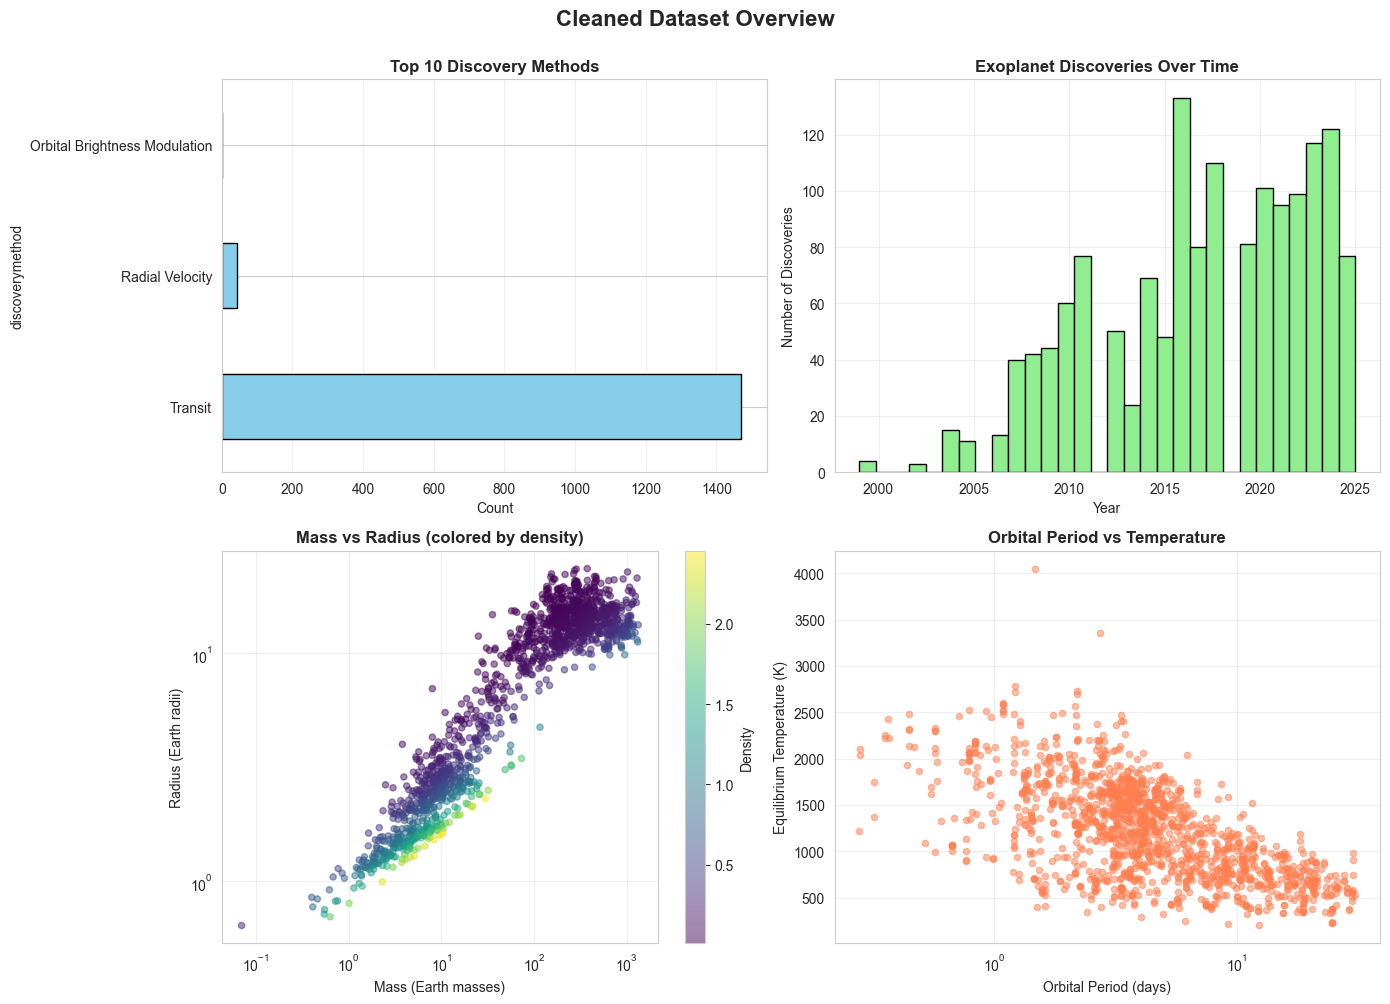


✓ Visualization saved as 'cleaned_data_summary.png'


In [38]:
# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Discovery methods distribution
ax1 = axes[0, 0]
method_counts = df_clean['discoverymethod'].value_counts().head(10)
method_counts.plot(kind='barh', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_xlabel('Count')
ax1.set_title('Top 10 Discovery Methods', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Discovery year distribution
ax2 = axes[0, 1]
df_clean['disc_year'].hist(bins=30, ax=ax2, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Discoveries')
ax2.set_title('Exoplanet Discoveries Over Time', fontweight='bold')
ax2.grid(alpha=0.3)

# 3. Mass vs Radius (cleaned data)
ax3 = axes[1, 0]
scatter = ax3.scatter(df_clean['pl_masse'], df_clean['pl_rade'], 
                     alpha=0.5, s=20, c=df_clean['density'], cmap='viridis')
ax3.set_xlabel('Mass (Earth masses)')
ax3.set_ylabel('Radius (Earth radii)')
ax3.set_title('Mass vs Radius (colored by density)', fontweight='bold')
ax3.set_xscale('log')
ax3.set_yscale('log')
plt.colorbar(scatter, ax=ax3, label='Density')
ax3.grid(alpha=0.3)

# 4. Orbital period vs temperature
ax4 = axes[1, 1]
ax4.scatter(df_clean['pl_orbper'], df_clean['pl_eqt'], alpha=0.5, s=20, color='coral')
ax4.set_xlabel('Orbital Period (days)')
ax4.set_ylabel('Equilibrium Temperature (K)')
ax4.set_title('Orbital Period vs Temperature', fontweight='bold')
ax4.set_xscale('log')
ax4.grid(alpha=0.3)

plt.suptitle('Cleaned Dataset Overview', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('cleaned_data_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'cleaned_data_summary.png'")

## 8. Export Cleaned Data

In [39]:
print(f"Exporting cleaned data to: {OUTPUT_FILE}\n")

df_clean.to_csv(OUTPUT_FILE, index=False)

import os
file_size = os.path.getsize(OUTPUT_FILE)

print("✓ Export successful!")
print(f"  File: {OUTPUT_FILE}")
print(f"  Size: {file_size:,} bytes ({file_size/1024:.2f} KB)")
print(f"  Rows: {len(df_clean):,}")
print(f"  Columns: {len(df_clean.columns)}")

Exporting cleaned data to: cleaned_exoplanets.csv

✓ Export successful!
  File: cleaned_exoplanets.csv
  Size: 140,070 bytes (136.79 KB)
  Rows: 1,515
  Columns: 10


In [40]:
# Create data cleaning report with proper formatting
report = f"""
{'='*80}
DATA CLEANING REPORT
{'='*80}
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

INPUT DATA:
  • File: {INPUT_FILE}
  • Initial rows: {len(df_raw):,}
  • Initial columns: {len(df_raw.columns)}

CLEANING OPERATIONS:
  1. Filtered to complete cases for critical features
  2. Created derived variable: density = mass/radius³
  3. Standardized text fields (discovery methods, names)
  4. Removed outliers using IQR method (multiplier=3.0)
  5. Applied domain knowledge filters

OUTPUT DATA:
  • File: {OUTPUT_FILE}
  • Final rows: {len(df_clean):,}
  • Final columns: {len(df_clean.columns)}
  • Retention rate: {(len(df_clean) / len(df_raw) * 100):.2f}%

CRITICAL FEATURES (Complete, no missing values):
  • pl_masse (mass)
  • pl_rade (radius)
  • pl_orbper (orbital period)
  • pl_eqt (equilibrium temperature)
  • density (derived variable)

DATA QUALITY:
  • No missing values in critical features: ✓
  • Outliers removed: ✓
  • Text fields standardized: ✓
  • Domain constraints validated: ✓

NUMERICAL FEATURE RANGES (after cleaning):
  • Mass: {df_clean['pl_masse'].min():.2f} to {df_clean['pl_masse'].max():.2f} Earth masses
  • Radius: {df_clean['pl_rade'].min():.2f} to {df_clean['pl_rade'].max():.2f} Earth radii
  • Orbital Period: {df_clean['pl_orbper'].min():.2f} to {df_clean['pl_orbper'].max():.2f} days
  • Temperature: {df_clean['pl_eqt'].min():.2f} to {df_clean['pl_eqt'].max():.2f} K
  • Density: {df_clean['density'].min():.2f} to {df_clean['density'].max():.2f} (relative to Earth)

CATEGORICAL FEATURE SUMMARY:
  • Discovery Methods: {df_clean['discoverymethod'].nunique()} unique
  • Host Stars: {df_clean['hostname'].nunique()} unique
  • Discovery Years: {df_clean['disc_year'].min():.0f} to {df_clean['disc_year'].max():.0f}

READY FOR:
  ✓ Exploratory Data Analysis
  ✓ Database implementation
  ✓ K-Means clustering analysis
{'='*80}
"""

print(report)

# Save report to file with explicit encoding
try:
    with open('data_cleaning_report.txt', 'w', encoding='utf-8') as f:
        f.write(report)
    print("\n✓ Report saved as 'data_cleaning_report.txt'")
    
    # Verify the file was written
    import os
    if os.path.exists('data_cleaning_report.txt'):
        file_size = os.path.getsize('data_cleaning_report.txt')
        print(f"  File size: {file_size:,} bytes")
        if file_size == 0:
            print("  ⚠ Warning: File is empty!")
        else:
            print(f"  ✓ File contains data")
except Exception as e:
    print(f"\n✗ Error saving report: {str(e)}")


DATA CLEANING REPORT
Date: 2025-12-06 11:25:24

INPUT DATA:
  • File: raw_exoplanets.csv
  • Initial rows: 39,158
  • Initial columns: 9

CLEANING OPERATIONS:
  1. Filtered to complete cases for critical features
  2. Created derived variable: density = mass/radius³
  3. Standardized text fields (discovery methods, names)
  4. Removed outliers using IQR method (multiplier=3.0)
  5. Applied domain knowledge filters

OUTPUT DATA:
  • File: cleaned_exoplanets.csv
  • Final rows: 1,515
  • Final columns: 10
  • Retention rate: 3.87%

CRITICAL FEATURES (Complete, no missing values):
  • pl_masse (mass)
  • pl_rade (radius)
  • pl_orbper (orbital period)
  • pl_eqt (equilibrium temperature)
  • density (derived variable)

DATA QUALITY:
  • No missing values in critical features: ✓
  • Outliers removed: ✓
  • Text fields standardized: ✓
  • Domain constraints validated: ✓

NUMERICAL FEATURE RANGES (after cleaning):
  • Mass: 0.07 to 1331.39 Earth masses
  • Radius: 0.64 to 23.54 Earth radii


## 9. Summary and Next Steps

### What We Accomplished:

1. ✅ **Identified missing values** - Comprehensive analysis of data completeness
2. ✅ **Filtered to complete cases** - Retained only planets with all critical features
3. ✅ **Created derived variable** - Calculated density for each planet
4. ✅ **Standardized text fields** - Ensured consistency in categorical data
5. ✅ **Removed outliers** - Applied both statistical and domain knowledge filters
6. ✅ **Exported clean data** - Saved `cleaned_exoplanets.csv` for next phase

### Data Quality Summary:

- **No missing values** in critical clustering features
- **Physically valid** data (positive values, reasonable ranges)
- **Standardized** text fields for consistency
- **Outliers removed** using rigorous statistical methods

### Next Steps:

1. **Quick EDA** - Create initial visualizations
2. **Database Design** - Design ER diagram and PostgreSQL schema
3. **K-Means Clustering**  - Perform clustering analysis on cleaned data

---

**Files Generated:**
- `cleaned_exoplanets.csv` - Clean dataset ready for analysis
- `missing_values_analysis.png` - Missing data visualization
- `density_distribution.png` - Density analysis
- `outliers_detection.png` - Outlier detection plots
- `cleaned_data_summary.png` - Final data overview
- `data_cleaning_report.txt` - Comprehensive cleaning report